In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [42]:
# Load the prepared data
X = np.load('../data/24hrs/X_24hr.npy')
y = np.load('../data/24hrs/y_24hr.npy')


In [43]:
X.shape

(18131, 48, 52)

In [46]:
y.shape

(18131,)

In [48]:
count_ones = np.sum(y == 1)

count_zeros = np.sum(y == 0)

print(f"Number of 1s: {count_ones}")
print(f"Number of 0s: {count_zeros}")

Number of 1s: 6825
Number of 0s: 11306


In [50]:
X[0].shape

(48, 52)

In [52]:
X[0]

array([[-0.58355812, -0.84382698, -0.88353501, ..., -0.83292097,
        -0.85003792, -0.64633824],
       [-0.58355812, -0.84382698, -0.88353501, ..., -0.83292097,
        -0.85003792, -0.64633824],
       [-0.58355812, -0.84382698, -0.88353501, ..., -0.83292097,
        -0.85003792, -0.64633824],
       ...,
       [ 1.71362538,  0.05990531,  1.09850294, ...,  0.98941435,
         1.05553278,  2.23945962],
       [ 1.71362538,  0.05990531,  1.09850294, ...,  0.98941435,
         1.05553278,  2.32771402],
       [ 1.71362538,  0.05990531,  1.09850294, ...,  0.98941435,
         1.05553278,  2.39541602]])

In [54]:
X[0][15]

array([-0.58355812, -0.84382698, -0.88353501, -0.83124718, -0.00685788,
       -0.00812086, -0.00287852, -0.03979434, -0.18630357, -0.1452517 ,
       -0.89168024, -0.88469119, -0.77631171, -0.879399  , -0.89105746,
       -0.79453444, -0.87953597, -0.89176072, -0.89189396, -0.87724095,
       -0.86195229, -0.86861972, -0.42147352, -0.89045155, -0.89148484,
       -0.89127912, -0.8915562 , -0.54301398, -0.89149974, -0.58228106,
       -0.88119599, -0.86393651, -0.88717492, -0.89160915, -0.89150122,
       -0.75165601, -0.88896169, -0.88719098, -0.8905254 , -0.88986258,
       -0.88629035, -0.44595227, -0.84133061, -0.89108609, -0.02745244,
       -0.01934372, -0.89088658, -0.84861785, -0.88814788, -0.83292097,
       -0.85003792, -0.64633824])

In [56]:
unique_values, counts = np.unique(y, return_counts=True)

# Print the results
for value, count in zip(unique_values, counts):
    print(f'Value {value} occurs {count} times')

Value 0 occurs 11306 times
Value 1 occurs 6825 times


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [60]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, LSTM, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

# Define Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.3):
    # Multi-Head Self-Attention
    attention = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    attention = Add()([attention, inputs])  # Residual connection
    attention = LayerNormalization(epsilon=1e-6)(attention)  # Layer normalization

    # Feed-forward network
    ff = Dense(ff_dim, activation='relu')(attention)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)  # Project back to original input shape
    ff = Add()([ff, attention])  # Residual connection
    ff = LayerNormalization(epsilon=1e-6)(ff)  # Layer normalization
    return ff

# Input layer for feature data (shape: 48 time steps, 51 features)
inputs = Input(shape=(48, 52))

# Transformer encoder layers for feature data
x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.3)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.3)

# LSTM layers to capture sequential dependencies
x = LSTM(64, activation='relu', return_sequences=True)(x)
x = LSTM(32, activation='relu')(x)

# Fully connected layer
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer for binary classification
outputs = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 48, 52)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_2        │ (None, 48, 52)            │          54,068 │ input_layer_1[0][0],       │
│ (MultiHeadAttention)          │                           │                 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_8 (Dropout)           │ (None, 48, 52)            │               0 │ multi_head_attention_2[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_4 (Add)                   │ (None, 48, 52)            │               0 │ dropout_8[0][0],           │
│                               │                           │                 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_4         │ (None, 48, 52)            │             104 │ add_4[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 48, 128)           │           6,784 │ layer_normalization_4[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 48, 128)           │               0 │ dense_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 48, 52)            │           6,708 │ dropout_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_5 (Add)                   │ (None, 48, 52)            │               0 │ dense_7[0][0],             │
│                               │                           │                 │ layer_normalization_4[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_5         │ (None, 48, 52)            │             104 │ add_5[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_3        │ (None, 48, 52)            │          54,068 │ layer_normalization_5[0][… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_5[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_11 (Dropout)          │ (None, 48, 52)            │               0 │ multi_head_attention_3[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_6 (Add)                   │ (None, 48, 52)            │               0 │ dropout_11[0][0],          │
│                               │                           │                 │ layer_normalization_5[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_6         │ (None, 48, 52)            │             10

 Total params: 178,993 (699.19 KB)

 Trainable params: 178,993 (699.19 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:

# from tensorflow.keras.callbacks import EarlyStopping
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



# # Train the model with Early Stopping
# history = model.fit(X_train, 
#                     y_train, 
#                     epochs=30, 
#                     batch_size=64, 
#                     validation_split=0.2)

# # Save the model
# # model.save('lstm_model_advanced.h5')

# # Save the model
# # model.save('lstm_model_advanced.h5')




history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)



Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 27s 65ms/step - accuracy: 0.7040 - loss: 0.5735 - val_accuracy: 0.7883 - val_loss: 0.5018
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.7949 - loss: 0.4636 - val_accuracy: 0.7601 - val_loss: 0.5207
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.7973 - loss: 0.4485 - val_accuracy: 0.8294 - val_loss: 0.3992
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - accuracy: 0.8172 - loss: 0.4216 - val_accuracy: 0.8359 - val_loss: 0.3797
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.8261 - loss: 0.4090 - val_accuracy: 0.8370 - val_loss: 0.3860
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.8429 - loss: 0.3803 - val_accuracy: 0.8445 - val_loss: 0.3646
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.8491 - loss: 0.3673 - val_accuracy: 0.8600 - val_loss: 0.3501
Epoch 8/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.8466 - loss: 0.3558 - 

In [63]:
# model.save('lstm_transformer_model_50epoch.h5')

In [64]:
# Step 3: Evaluate the model
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
y_pred_proba = model.predict(X_test)
y_pred = (model.predict(X_test) > 0.33).astype(int)

# Calculate precision, recall, F1 score, and accuracy
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Accuracy: {accuracy:.2f}')


114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Precision: 0.77
Recall: 0.84
F1 Score: 0.80
Accuracy: 0.85


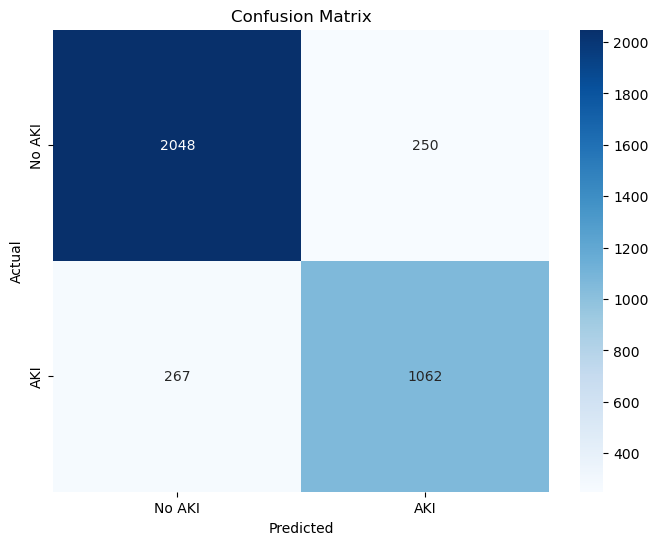

In [69]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No AKI', 'AKI'], yticklabels=['No AKI', 'AKI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

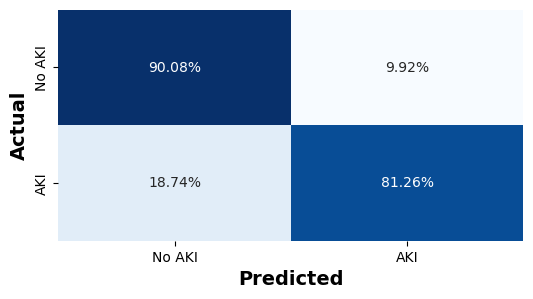

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert to percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create a new matrix for the annotations with both counts and percentages
cm_annot = np.array([["{:.2f}%".format( cm_percent[i, j]) for j in range(cm.shape[1])] for i in range(cm.shape[0])])

# Plot Confusion Matrix as percentages with annotations
plt.figure(figsize=(6, 3))
sns.heatmap(cm_percent, annot=cm_annot, fmt='', cmap='Blues', xticklabels=['No AKI', 'AKI'], yticklabels=['No AKI', 'AKI'], cbar=False)
plt.xlabel('Predicted', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Actual', fontsize=14, fontweight='bold', color='black')
plt.show()

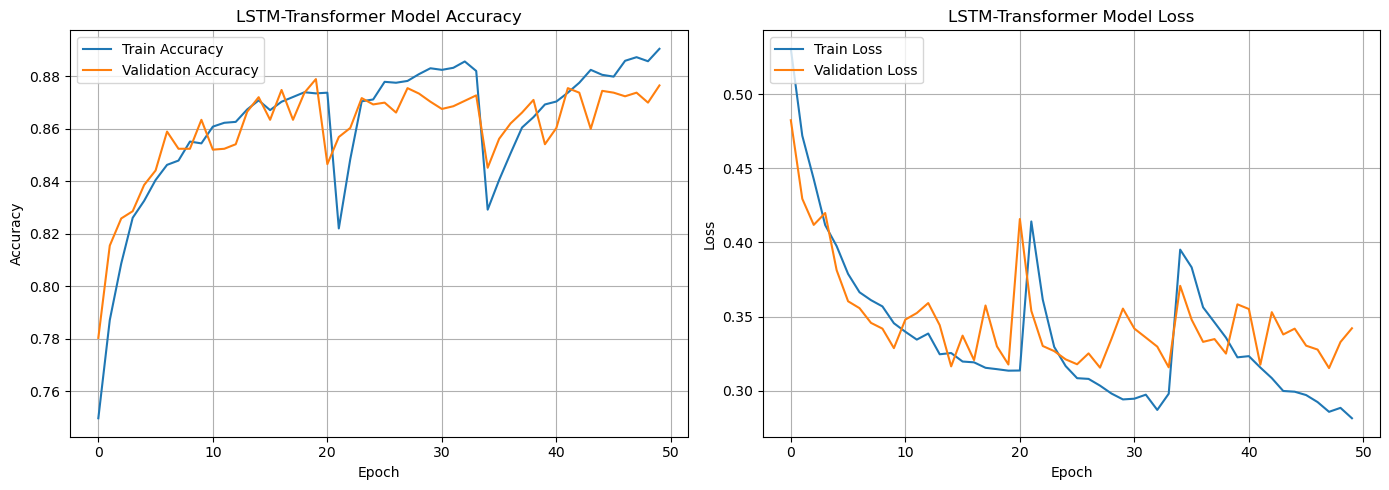

In [32]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM-Transformer Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM-Transformer Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()


[0.4823913276195526,
 0.4294625520706177,
 0.4118659198284149,
 0.41986140608787537,
 0.3813438415527344,
 0.3603937327861786,
 0.3557233214378357,
 0.34582921862602234,
 0.3419366478919983,
 0.3288043439388275,
 0.3480532467365265,
 0.35245099663734436,
 0.3591884970664978,
 0.3442969024181366,
 0.3165092468261719,
 0.3372393846511841,
 0.32072335481643677,
 0.357544869184494,
 0.32997748255729675,
 0.3177744746208191,
 0.415807843208313,
 0.35393014550209045,
 0.3302516043186188,
 0.3267976641654968,
 0.3212372362613678,
 0.3179352879524231,
 0.3252643644809723,
 0.3156643211841583,
 0.33502113819122314,
 0.35545098781585693,
 0.3419637680053711,
 0.3359226584434509,
 0.32982057332992554,
 0.31587037444114685,
 0.37080228328704834,
 0.34799110889434814,
 0.3330305516719818,
 0.3349052965641022,
 0.32512086629867554,
 0.3583138585090637,
 0.35517221689224243,
 0.31764158606529236,
 0.3530418276786804,
 0.33801719546318054,
 0.34193524718284607,
 0.3304644823074341,
 0.3278344571590423

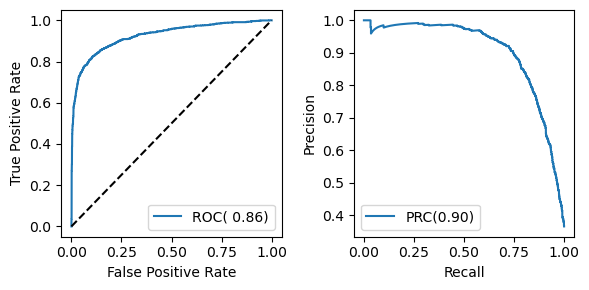

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# Assuming y_true are the true labels and y_scores are the predicted probabilities

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auroc = roc_auc_score(y_test, y_pred)

# Calculate Precision-Recall curve and AUPRC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
auprc = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC( %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label='PRC(%0.2f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

In [65]:
np.save('../Scores/validation_loss/LT24-VL.npy', np.array(history.history['val_loss']))
np.save('../Scores/validation_accuracy/LT24-VA.npy', np.array(history.history['val_accuracy']))
np.save('../Scores/training_accuracy/LT24-TA.npy', np.array(history.history['accuracy']))
np.save('../Scores/training_loss/LT24-TL.npy', np.array(history.history['loss']))


np.save('../Scores/ROC-PRC/LT24-y_test.npy', np.array(y_test))
np.save('../Scores/ROC-PRC/LT24-y_pred.npy', np.array(y_pred))
np.save('../Scores/ROC-PRC/LT24-y_pred_proba.npy', np.array(y_pred_proba))